In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = 'svg'

## LSTM

In [6]:
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm


def denormalize(test_y, Aprice_data):
    return test_y * (
        np.max(Aprice_data["3_day_return"]) - np.min(Aprice_data["3_day_return"])
    ) + np.mean(Aprice_data["3_day_return"])


def train_(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0] - predict_day - ref_day):
        X_train.append(np.array(df.iloc[i : i + ref_day, 1:]))
        Y_train.append(
            np.array(df.iloc[i + ref_day : i + ref_day + predict_day]["3_day_return"])
        )
    return np.array(X_train), np.array(Y_train)


def train(df, title=None, split_boundary=2110):
    Aprice_data = df

    norm_Aprice_data = normalize(Aprice_data)

    # 7 days predict 1 day
    X, Y = train_(norm_Aprice_data, 7, 1)
    train_x = X[:split_boundary]
    test_x = X[split_boundary:]
    train_y = Y[:split_boundary]
    test_y = Y[split_boundary:]

    regressor = Sequential()
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(train_x.shape[1], train_x.shape[2]),
        )
    )
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))
    regressor.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

    history = regressor.fit(train_x, train_y, epochs=1000, batch_size=128, verbose=0)

    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(
        go.Scatter(y=history.history["loss"], name="training loss"), row=1, col=1
    )

    score = regressor.evaluate(
        test_x, test_y, verbose=0
    )
    predict_y = regressor.predict(test_x)
#     norm_mse = mean_squared_error(test_y, predict_y)
    test_y_list = denormalize(test_y, Aprice_data).ravel()
    predict_y_list = denormalize(predict_y, Aprice_data).ravel()
    mean = np.mean(np.abs(np.array(predict_y_list) - np.array(test_y_list)))
    
    fig.add_trace(
        go.Scatter(y=test_y_list, mode="lines", name="actual return"), row=2, col=1
    )
    fig.add_trace(
        go.Scatter(y=predict_y_list, mode="lines", name="predict return"), row=2, col=1
    )
    fig.update_layout(
        title_text="Crops : {}, Loss : {}, Mean: {}".format(title, score[0], mean),
    )
    fig.show()

crops_arr = [
    "香蕉",
    "洋香瓜-網狀紅肉",
    "蓮霧-紅蓮霧",
    "鳳梨-金鑽鳳梨",
    "南瓜-木瓜形",
    "大蒜-蒜瓣",
    "青蔥-日蔥",
    "小白菜-土白菜",
    "芽菜類-黃豆牙",
    "木瓜-網室紅肉",
]

## Predict without feature selection

### 1 days return

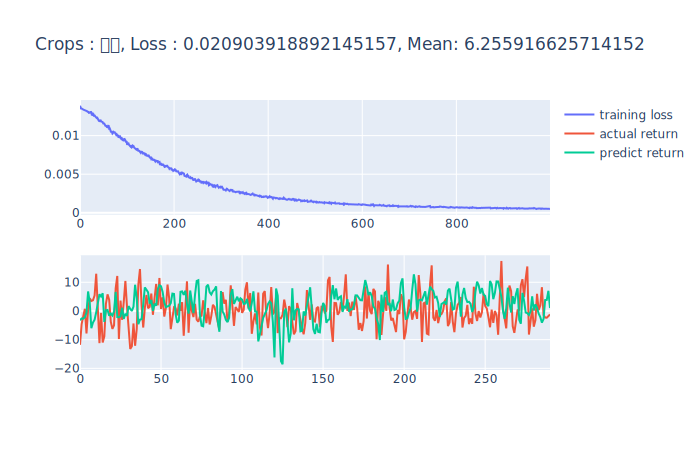

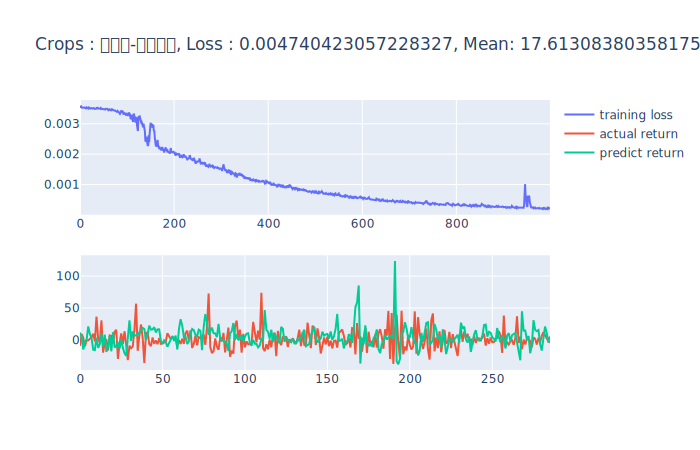

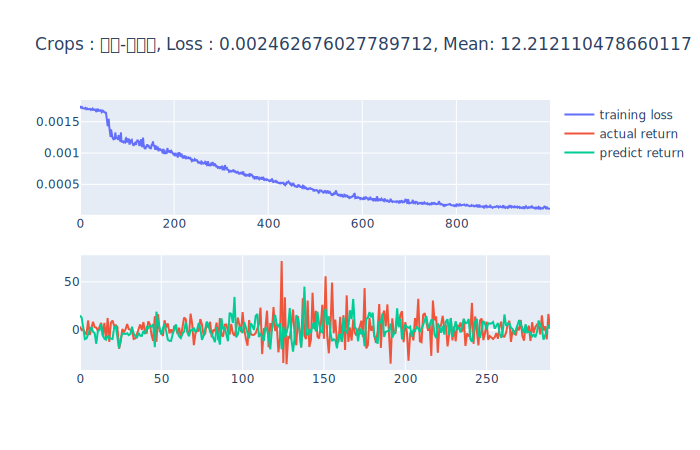

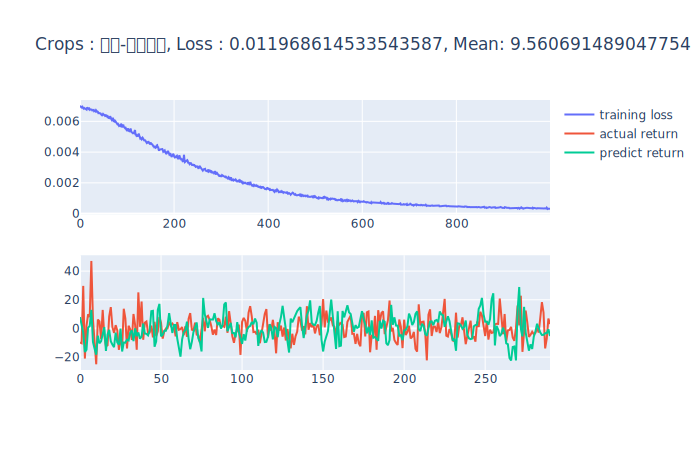

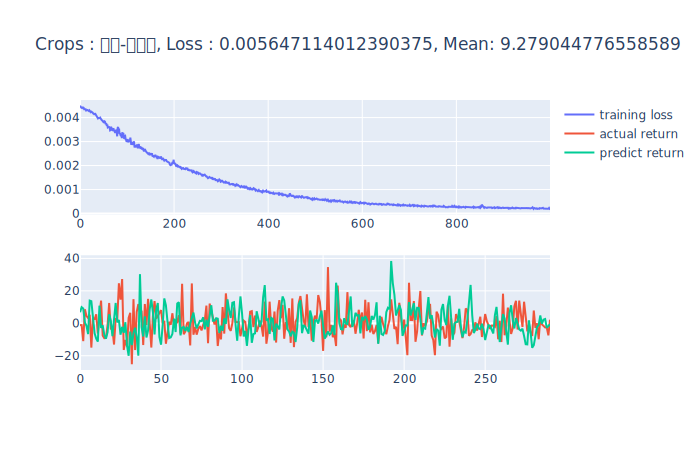

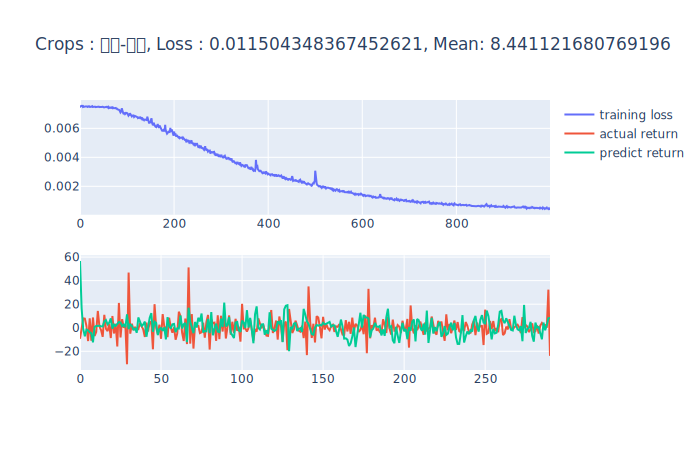

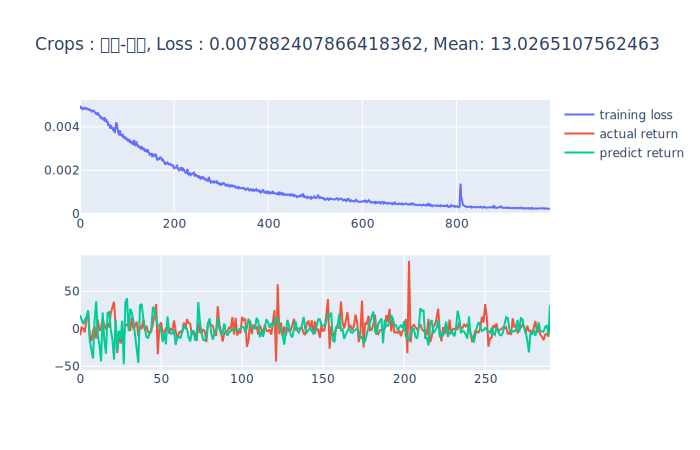

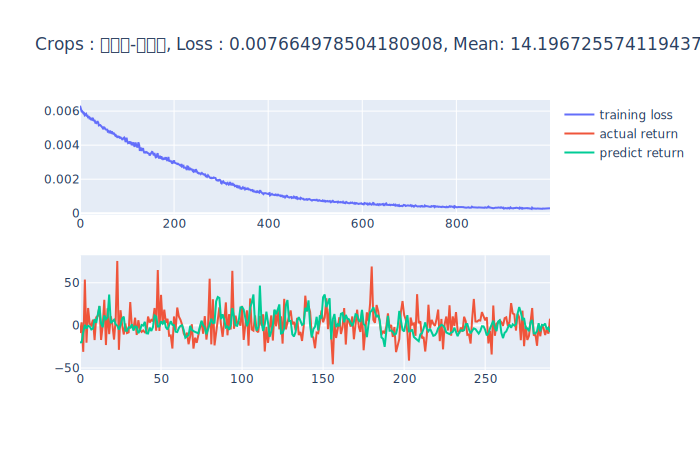

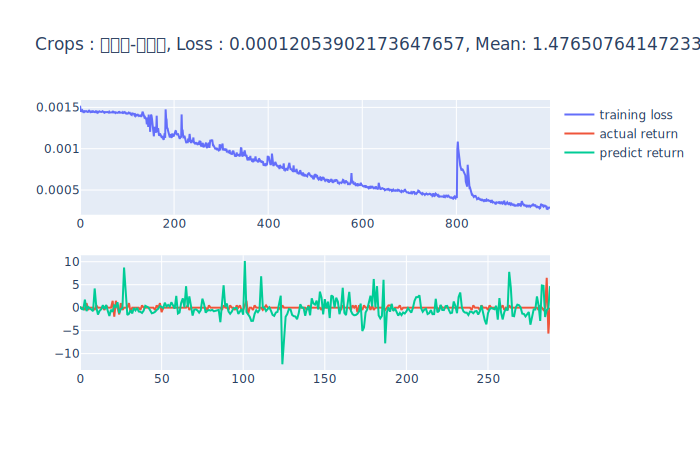

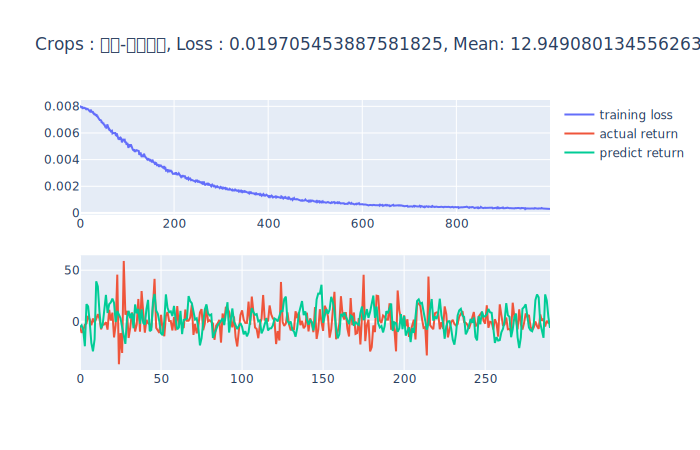

In [5]:
# change 'x_day_return' on above fn before running model

for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    train(
        df.drop(columns=["DateTime", "市場代號", "平均價", "3_day_return", "5_day_return"]),
        crops,
        split_boundary,
    )

### 3 day return

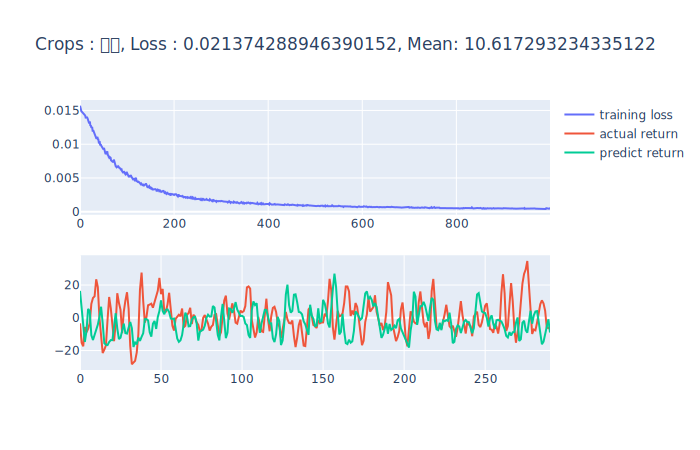

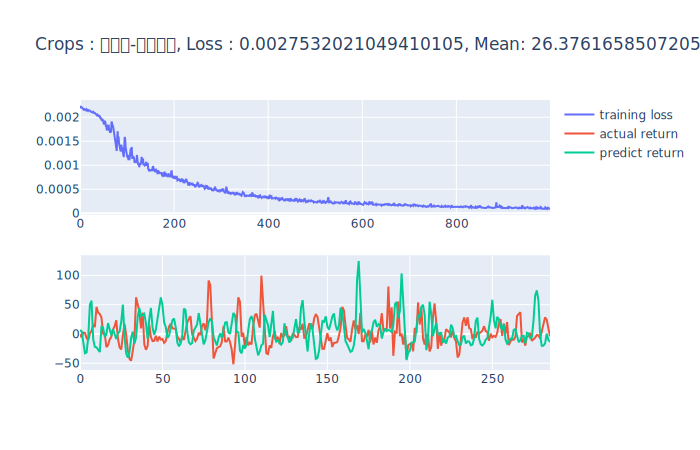

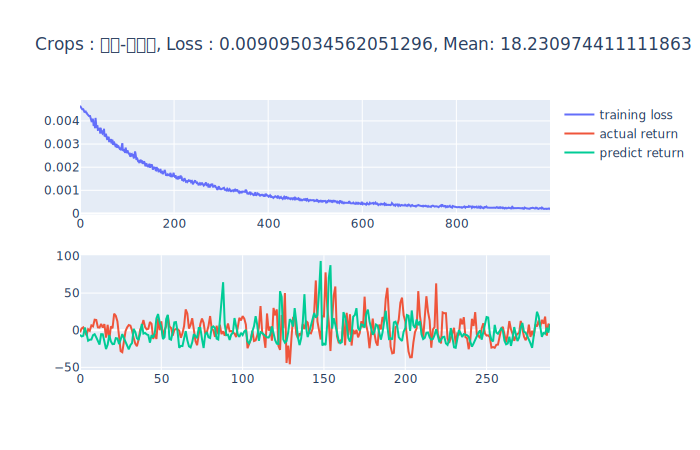

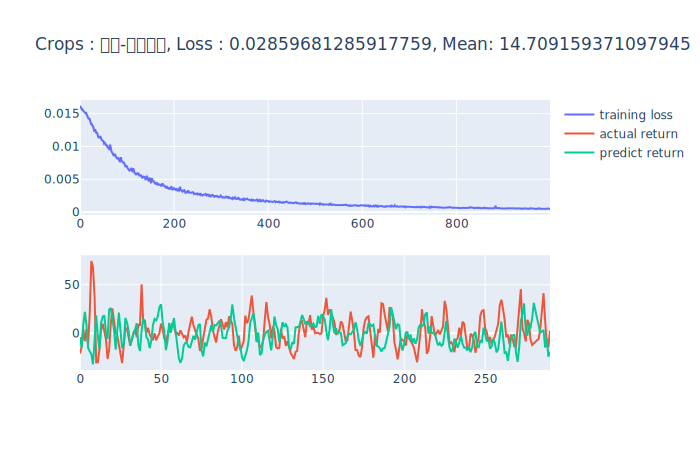

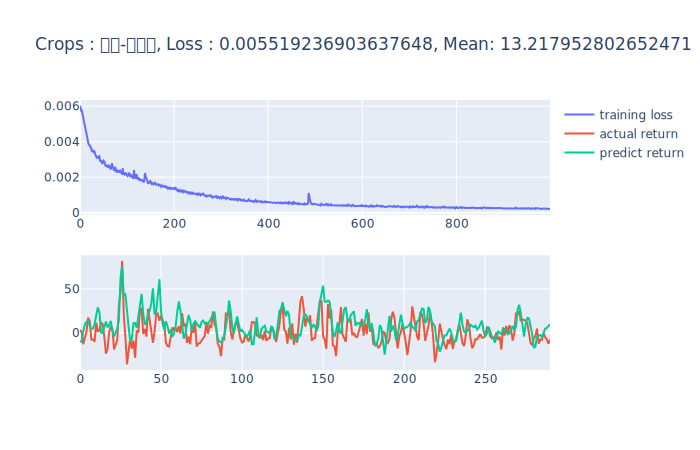

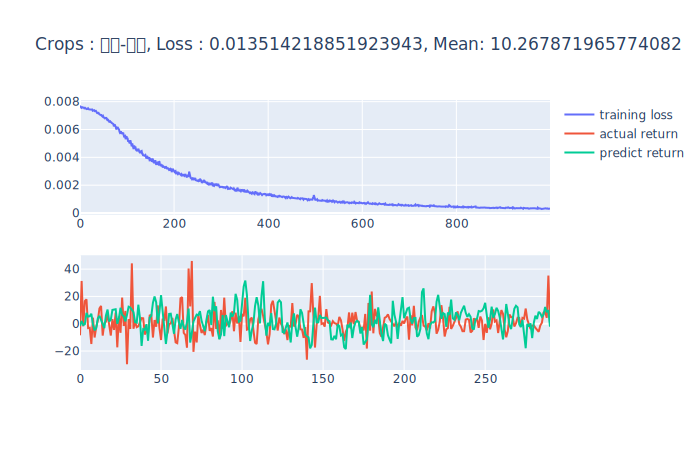

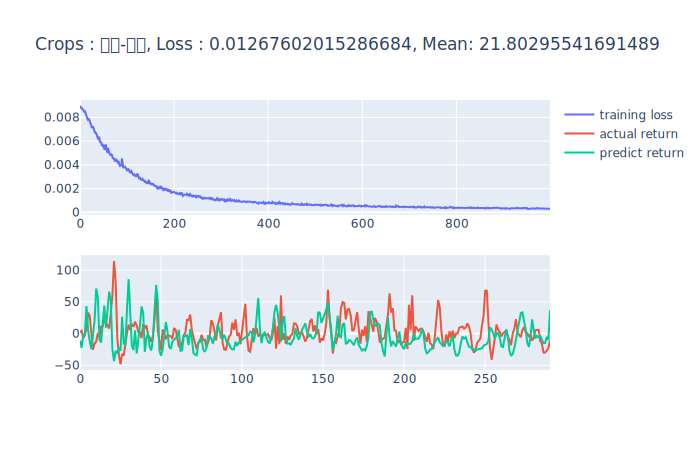

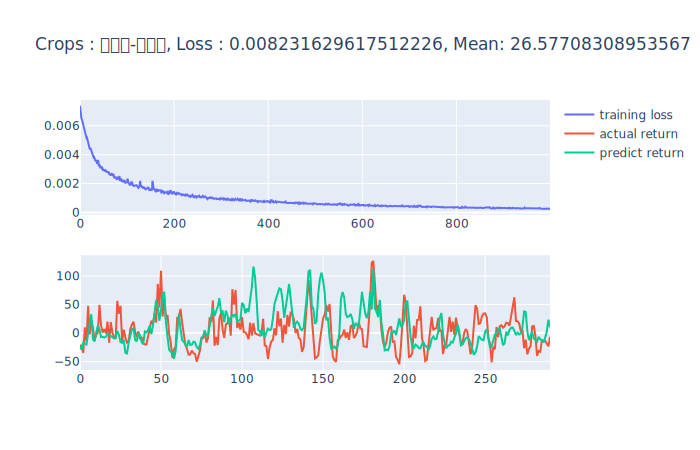

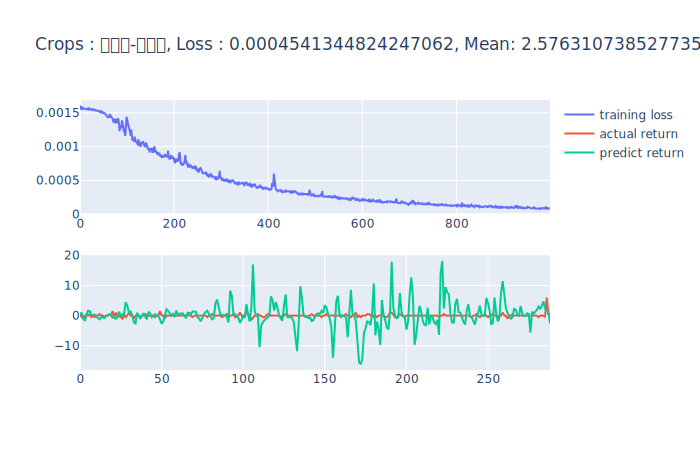

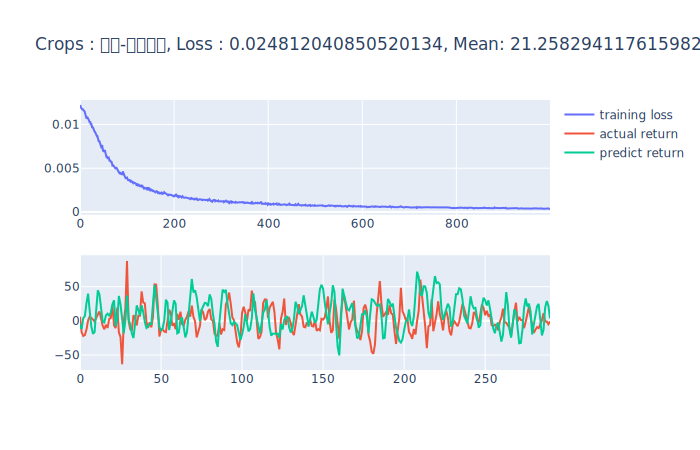

In [7]:
# change 'x_day_return' on above fn before running model

for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    train(
        df.drop(columns=["DateTime", "市場代號", "平均價", "1_day_return", "5_day_return"]),
        crops,
        split_boundary,
    )

## Predict with feature selection
### 雲林 : C0K240, 彰化 : C0G660, 嘉義 : 467480
- [ref](https://www-ws.gov.taipei/Download.ashx?u=LzAwMS9VcGxvYWQvMzY3L3JlbGZpbGUvNDUwMDAvNzY2MjU4NC8yNmYwZTlmNC1jNjIyLTQ2YmMtYTFlYi1hMDc4MWUxMTcxZGYucGRm&n=MTA0MDLporHpoqjlsI3oh7rljJfluILolKzoj5zlg7nmoLzlvbHpn7%2FliIbmnpAucGRm&icon=.pdf)

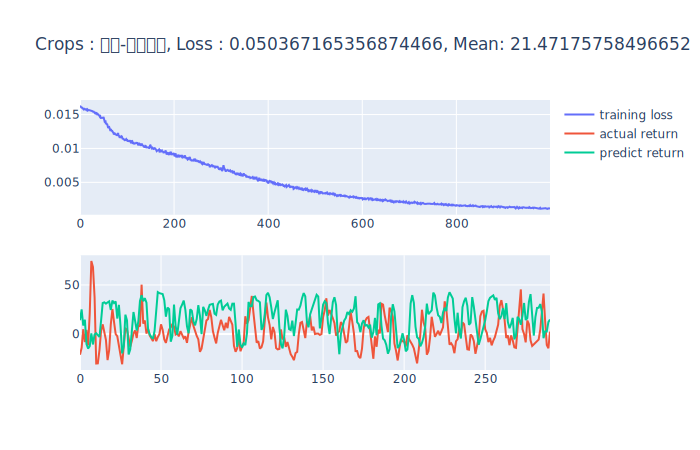

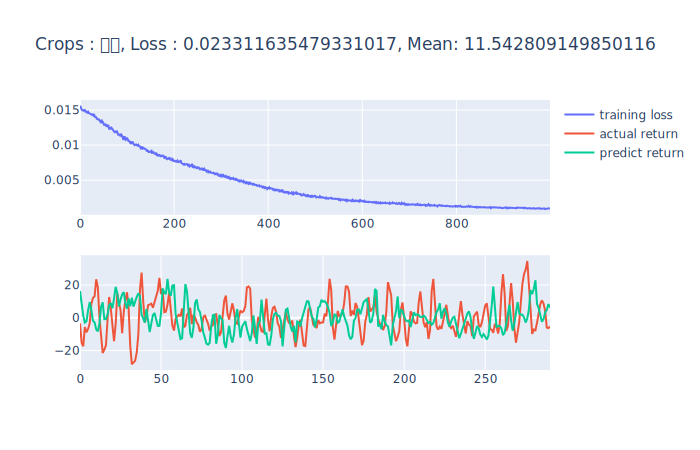

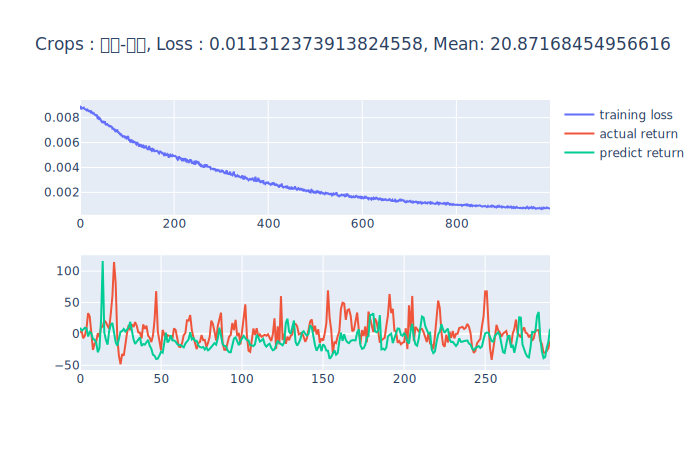

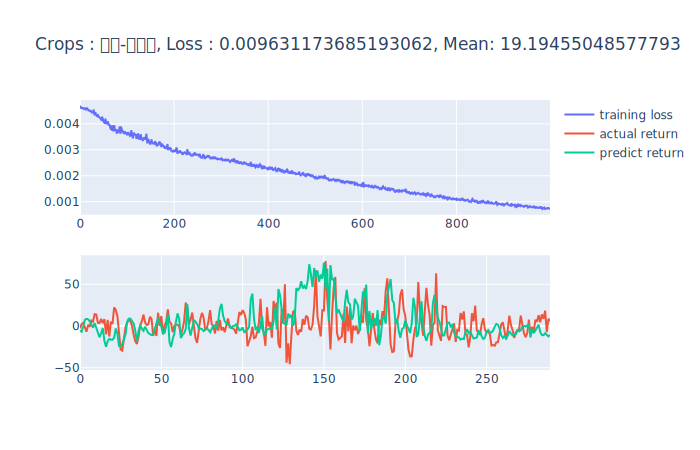

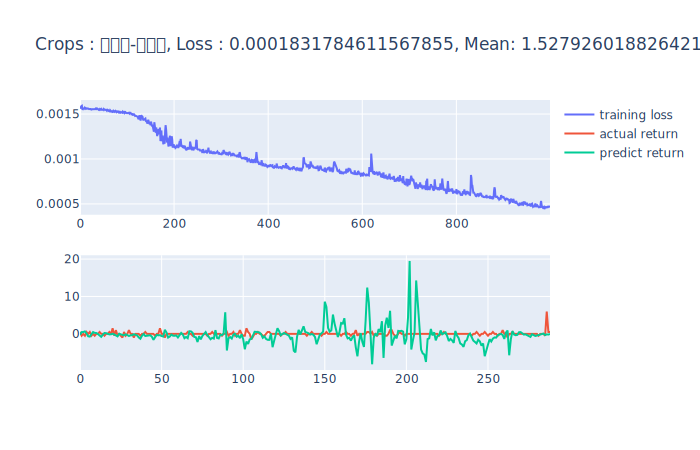

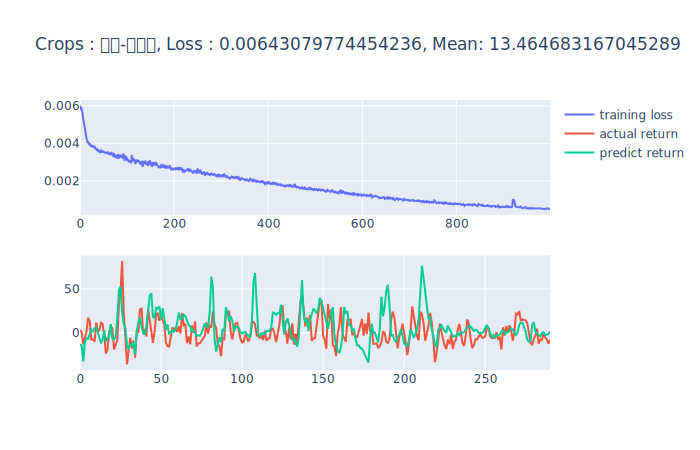

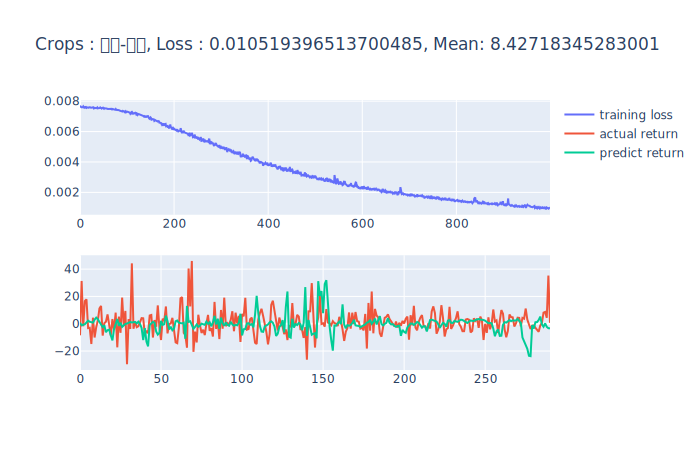

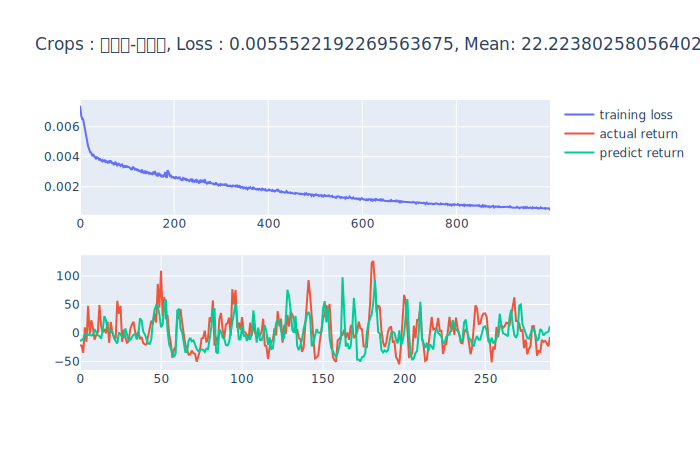

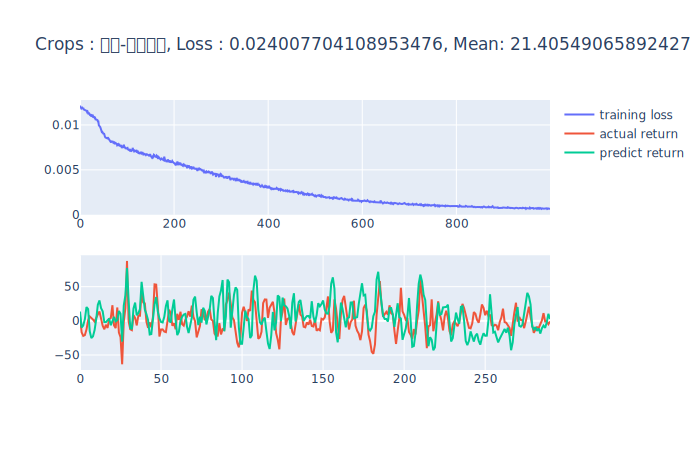

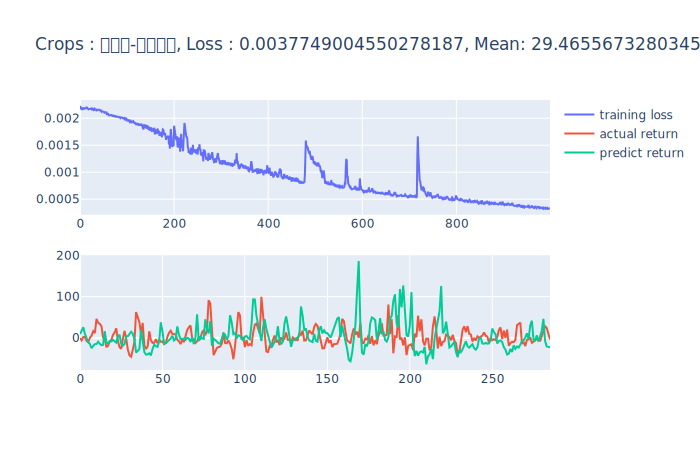

In [10]:
for crops in crops_arr:
    df = pd.read_csv('../data/{}.csv'.format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    df = df[
        [
            "3_day_return",
            "交易量",
            "強度",
            "警報發布報數",
            "C0K240_StnPres",
            "C0K240_Temperature",
            "C0K240_WS",
            "C0K240_WSGust",
            "C0K240_Precp",
            "C0G660_StnPres",
            "C0G660_Temperature",
            "C0G660_WS",
            "C0G660_WSGust",
            "C0G660_Precp",
            "467480_StnPres",
            "467480_Temperature",
            "467480_WS",
            "467480_WSGust",
            "467480_Precp"
        ]
    ]
    train(df, crops, split_boundary)

[0.019499247893691063, 0.019499247893691063]
0.019499246014790514


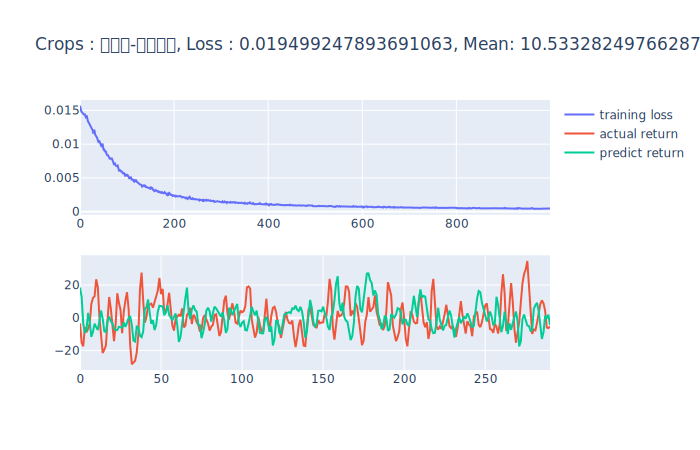

In [8]:
# norm_mse vs evaluate_mse
# df = pd.read_csv("../data/香蕉.csv")
# split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
# train(df.drop(columns=["DateTime", "市場代號", "平均價", "1_day_return", "5_day_return"]), crops, split_boundary)

In [16]:
df = pd.read_csv("../data/香蕉.csv")

In [17]:
df

,市場代號,平均價,1_day_return,3_day_return,5_day_return,交易量,DateTime,強度,警報發布報數,C0A530_StnPres,...,C0Z061_StnPres,C0Z061_Temperature,C0Z061_WS,C0Z061_WSGust,C0Z061_Precp,467660_StnPres,467660_Temperature,467660_WS,467660_WSGust,467660_Precp
0,109.0,18.2,0.000000,0.000000,0.000000,21521.0,2012-01-01,0.0,0.0,988.0,...,1004.9,14.7,0.6,5.6,2.0,1019.6,18.4,1.6,9.4,0.0
1,109.0,18.4,1.098901,0.000000,0.000000,14700.0,2012-01-03,0.0,0.0,985.7,...,1002.6,16.9,0.6,7.7,0.0,1017.9,19.5,1.6,6.6,0.0
2,109.0,18.9,2.717391,0.000000,0.000000,19953.0,2012-01-04,0.0,0.0,990.9,...,1007.2,13.0,1.4,7.8,0.5,1021.8,17.1,2.5,13.2,0.0
3,109.0,18.8,-0.529101,3.296703,0.000000,18523.0,2012-01-05,0.0,0.0,988.5,...,1006.7,12.5,0.4,4.4,0.5,1021.6,15.2,1.5,6.7,0.4
4,109.0,19.5,3.723404,5.978261,0.000000,22340.0,2012-01-06,0.0,0.0,987.0,...,1004.0,15.5,0.4,4.4,2.0,1019.2,18.4,1.3,6.3,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,109.0,34.0,-2.298851,4.294479,6.583072,21945.0,2019-12-26,0.0,0.0,983.6,...,999.6,20.8,0.7,7.6,0.0,1013.9,23.2,2.7,14.4,0.0
2406,109.0,33.2,-2.352941,-5.949008,3.750000,15308.0,2019-12-27,0.0,0.0,988.5,...,1005.5,15.7,1.0,5.5,0.5,1019.2,19.3,2.8,15.1,0.0
2407,109.0,32.6,-1.807229,-6.321839,0.000000,17840.0,2019-12-28,0.0,0.0,986.9,...,1005.9,17.1,0.5,4.5,0.0,1020.1,19.8,2.1,10.3,0.8
2408,109.0,32.2,-1.226994,-5.294118,-8.781870,13077.0,2019-12-29,0.0,0.0,984.9,...,1004.3,17.8,0.4,3.6,69.5,1018.4,19.4,1.4,8.2,66.0
